## Deasonalize

This notebook provides code for a deseasonalised model for one counter. If we had more time, we could have implemented this idea for all counters as the RMSE was very promising

In [1]:
#from workalendar.europe import France
import pandas as pd
import numpy as np
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.preprocessing import TargetEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from sktime.forecasting.compose import make_reduction
from sklearn.compose import ColumnTransformer
from sktime.transformations.series.detrend import Deseasonalizer
from xgboost import XGBRegressor
from datetime import datetime

from sklearn.model_selection import cross_val_score,TimeSeriesSplit

def categorize_time(X):
      # Access the 'hour' column from the DataFrame row
    
    def categorize(hour):
        if 5 <= hour < 9:
            return '5-9'
        elif 9 <= hour < 14:
            return '9-14'
        elif 14 <= hour < 21:
            return '14-21'
        elif 21 <= hour or hour < 5:
            return '21-5'
    
    X['time_category'] = X['hour'].apply(categorize)
    return X
    
conf = [(datetime(2020, 3, 17), datetime(2020, 5, 10)), (datetime(2020, 10, 30), datetime(2020, 11, 27)), (datetime(2021, 4, 3), datetime(2021, 5, 2))]
conf_a = [(datetime(2020, 5, 11), datetime(2020, 6, 1)), (datetime(2020, 11, 28), datetime(2020, 12, 15))]
c_v = [(datetime(2020,10,15), datetime(2020,10,29)), (datetime(2020, 12, 16), datetime(2021, 4, 2)), (datetime(2021, 5, 3), datetime(2021, 6, 20))]

def is_in_range(date):
    for start, end in conf:
        if start <= date <= end:
            return 1
    for start, end in conf_a:
        if start <= date <= end:
            return 1
    for start, end in c_v:
        if start <= date <= end:
            return 1
    if date == datetime(2020, 12, 25):
        return 2
    else:
        return 0

def apply_confinement_status(X):
    X = X.copy()  
    X['Confinement'] = X['date'].apply(is_in_range)
    return X


def _encode_dates(X):
    X = X.copy()
    X['date'] = pd.to_datetime(X['date'])
    X['year'] = X['date'].dt.year
    X['month'] = X['date'].dt.month
    X['day'] = X['date'].dt.day
    X['weekday'] = X['date'].dt.weekday
    X['hour'] = X['date'].dt.hour
    return X

def encode_season(X):
   
    # Assuming X is a DataFrame with a 'month' column
    X = X.copy()  # To avoid modifying the original DataFrame
    X['season'] = X['month'].apply(lambda x: 'Winter' if x in [12, 1, 2] 
                                          else 'Spring' if x in [3, 4, 5] 
                                          else 'Summer' if x in [6, 7, 8] 
                                          else 'Autumn')
    
    return X

def split_address_and_map_direction(X):
    # Split the 'counter_name' into two columns 'Address' and 'Direction'
    X[['Address', 'Direction']] = X['counter_name'].str.rsplit(' ', n=1, expand=True)

    # Define the direction mapping
    direction_mapping = {
        'E-O': 1, 'O-E': -1, 'NO-SE': 1, 'SE-NO': -1, 'SO-NE': 1, 'SE-NO': -1, 'N-S': 1, 'S-N': -1,
    }

    # Apply the mapping to the 'Direction' column
    X['Direction'] = X['Direction'].map(direction_mapping)
    X['Direction'].fillna(1, inplace=True)

    return X




def _distance_from_paris_centre(X):
    X = X.copy()  
    X.loc[:, 'distance_paris_centre'] = np.sqrt((X['latitude']-48.8565)*2 + (X['longitude']-2.3426)*2)
    
    return X



def covid_scaled_count(X):
    X = X.copy()

    # Define the COVID impact factors
    covid_impact_conf = 1.23
    covid_impact_cv = 1.16

    # Define date ranges for confinements (conf) and couvre-feu (c_v)
    conf = [(datetime(2020, 10, 30), datetime(2020, 12, 15)), (datetime(2021, 4, 3), datetime(2021, 5, 2))]
    c_v = [(datetime(2020, 10, 15), datetime(2020, 10, 29)), (datetime(2020, 12, 16), datetime(2021, 4, 2)), (datetime(2021, 5, 3), datetime(2021, 6, 20))]

    # Initialize a column for scaled bike counts
    X['scaled_bike_count'] = X['bike_count']

    # Apply the conf impact factor
    for start, end in conf:
        conf_mask = (X['date'] >= start) & (X['date'] <= end)
        X.loc[conf_mask, 'scaled_bike_count'] *= covid_impact_conf

    # Apply the c_v impact factor
    for start, end in c_v:
        cv_mask = (X['date'] >= start) & (X['date'] <= end)
        X.loc[cv_mask, 'scaled_bike_count'] *= covid_impact_cv

    return X

def covid_scaled_log_count(X):
    X = X.copy()
    # Apply ln(x+1) transformation to the scaled_bike_count
    X['scaled_log_bike_count'] = np.log1p(X['scaled_bike_count'])
    return X


def column_to_drop(X):
    return X.drop([ 'day','date','longitude', 'latitude', 'counter_installation_date',
                  'counter_technical_id','counter_id', 'site_name', 'site_id','average_wind_speed','u','horizontal_visibility'], axis=1)



###########
def calculate_time_since_installation(X):
    X = X.copy()  # To avoid modifying the original DataFrame
    X['counter_installation_date'] = pd.to_datetime(X['counter_installation_date'])
    X['Time_since_installation'] = X['date'].dt.date - X['counter_installation_date'].dt.date
    X['Time_since_installation'] = X['Time_since_installation'].apply(lambda x: x.days)
    return X


def get_elevation_for_dataframe(X):
    # Define the function to get elevation
    def get_elevation(lat, lon):
        url = f"https://api.open-elevation.com/api/v1/lookup?locations={lat},{lon}"
        response = requests.get(url)
        if response.status_code == 200:
            elevation = response.json()['results'][0]['elevation']
            return elevation
        else:
            return None  # Return None or a default value if the API call fails

    # Get unique latitude-longitude pairs
    unique_lat_lon = X[['latitude', 'longitude']].drop_duplicates()

    # Get elevation for each unique pair
    unique_lat_lon['elevation'] = unique_lat_lon.apply(lambda row: get_elevation(row['latitude'], row['longitude']), axis=1)

    # Create a dictionary for mapping
    elevation_dict = dict(zip(unique_lat_lon['latitude'], unique_lat_lon['elevation']))

    # Map the elevation to the DataFrame
    X['Elevation'] = X['latitude'].map(elevation_dict)

    return X


def is_holiday_and_weekend(X):
    X = X.copy()
    
    # Initialize the France calendar from the workalendar library
    # Convert 'year', 'month', 'day' to a datetime object
    X['date_x'] = pd.to_datetime(X[['year', 'month', 'day']])

    # Add a column for public holidays
    #X['is_public_holiday'] = X['date'].apply(lambda x: cal.is_holiday(x)).astype(int)
    
    X['near_christmas'] = X['date_x'].apply(
    lambda x: (pd.Timestamp(year=x.year, month=12, day=25) - pd.Timedelta(days=5) <= x <= pd.Timestamp(year=x.year, month=12, day=25) + pd.Timedelta(days=5))
    ).astype(int)
    # Add a column for weekends
    # 5 and 6 represent Saturday and Sunday in 'weekday' column
    X['is_weekend'] = X['weekday'].apply(lambda x: x in [5, 6]).astype(int)
    X.drop('date_x',inplace=True,axis=1)

    return X

def combined_transformer(X):
    
    X = _encode_dates(X)
    X = _distance_from_paris_centre(X)
    X=encode_season(X)
    X=categorize_time(X)
    X=apply_confinement_status(X)
    X=is_holiday_and_weekend(X)
    X = column_to_drop(X)
    print(X.info())

    return X


class CyclicalEncoder(BaseEstimator, TransformerMixin):
    def init(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for column in ['hour']:
            if column in X.columns:
                max_val = X[column].max()
                X[f'sin_{column}'] = np.sin(2 * np.pi * X[column] / max_val)
                X[f'cos_{column}'] = np.cos(2 * np.pi * X[column] / max_val)
                

        return X

class ArrayToDataFrame(TransformerMixin, BaseEstimator):
    def __init__(self, transformer):
        self.transformer = transformer

    def fit(self, X, y=None):
        # Fit the transformer to get the new feature names
        
        return self
    
    def transform(self, X):
        # Get the feature names from the transformer
        
        
        feature_names = self.transformer.get_feature_names_out()
    
        # Convert array to DataFrame with the correct column names
        X=pd.DataFrame(X, columns=feature_names)

        columns_to_convert = X.columns.difference(['remainder__date'])
        X[columns_to_convert] = X[columns_to_convert].astype(float)
        
        # Save the current index in a new column Convert 'date' to datetime if not already
        X['remainder__date'] = pd.to_datetime(X['remainder__date'])
        
        X = X.set_index('remainder__date', drop=False)
        X=X.sort_index()
        X.drop('remainder__date',inplace=True,axis=1)
        nan_rows = X.isna().any(axis=1)

        # Get the index of rows with NaN values
        nan_index =X[nan_rows].index
        X.fillna(method='ffill',inplace=True)
   
        
        print(X.shape)
       
        
        return X 
    
    

def get_estimator():
    cyclical_encoder = CyclicalEncoder()
    data_encoder = FunctionTransformer(combined_transformer)
    categorical_encoder = OneHotEncoder(handle_unknown="ignore")
    target_cols=['counter_name']
    categorical_cols = ['weekday','month','season','time_category','year']
    standardize_cols = ['Temperature','distance_paris_centre']
    standardizer = StandardScaler()

    preprocessor = ColumnTransformer(
        [
            ("target_enc", TargetEncoder(), target_cols),
            ("stand", standardizer, standardize_cols),
            ("cat", categorical_encoder, categorical_cols),
        ],remainder='passthrough'
    )
    array_to_df = ArrayToDataFrame(preprocessor)
    
    regressor = XGBRegressor(
        objective='reg:squarederror',
        subsample=0.5,
        reg_alpha = 0,
        reg_lambda= 10,
        n_estimators = 300,
        max_depth = 10,
        learning_rate=0.05,
        gamma=0,
        colsample_bytree= 0.5,
    )

    pipe = make_pipeline(data_encoder ,cyclical_encoder, preprocessor ,regressor)
    
    return pipe



# Load data
df_train = pd.read_parquet('Data/train.parquet')



### IMPLEMENT SCALED FACTOR FOR COVID on df_train
df_train = covid_scaled_count(df_train)
df_train = covid_scaled_log_count(df_train)

df_train['date']=pd.to_datetime(df_train['date'])

weather=pd.read_csv("data/external_data.csv",sep='or|,+', engine='python')
weather=weather[['date','t','ff','vv','u','rr1']]


new_name= {'t' : 'Temperature' , 'ff' : 'average_wind_speed','vv' : 'horizontal_visibility','rr1' : 'rain_l_1'}

weather.rename(columns=new_name,inplace=True)
weather['rain_l_1'].bfill(inplace=True)
weather['date']=pd.to_datetime(weather['date'])

start_date = datetime.strptime('2020-09-01 01:00:00', "%Y-%m-%d %H:%M:%S")
end_date = datetime.strptime('2021-09-09 23:00:00', "%Y-%m-%d %H:%M:%S")

# Filter the DataFrame
weather_train = weather[(start_date <= weather['date']) & (weather['date'] <= end_date)]
weather_train = weather_train.copy()
weather_train.drop(2018, inplace=True)
weather_train = weather_train.set_index('date')

# Resample to hourly and forward fill the missing values
df_hourly = weather_train.resample('H').ffill()

# Reset index to get 'date' back as a column
weather_hourly = df_hourly.reset_index()
df_train.reset_index(inplace=True)
df_train = pd.merge(df_train,weather_hourly,on='date' ) 
df_train.set_index('index',inplace=True)
df_train= df_train.sort_index()

df_train.head()

# Extract features and target
X_train = df_train[df_train['counter_name']==df_train['counter_name'].unique()[3]].drop(columns=['log_bike_count', 'bike_count', 'scaled_bike_count', 'scaled_log_bike_count'])
y_train = df_train[df_train['counter_name']==df_train['counter_name'].unique()[3]][['scaled_log_bike_count']]

deseasonalizer = Deseasonalizer(model='additive', sp=24)
actual=df_train[df_train['counter_name']==df_train['counter_name'].unique()[3]]
actual=actual[['date','scaled_log_bike_count']]
pd.to_datetime(actual['date'])
actual.fillna(method='ffill', inplace=True)
actual.set_index('date',inplace=True)
actual.sort_index(inplace=True)
     
actual=actual.asfreq('H')
actual.fillna(method='ffill', inplace=True)
    
deseasonalized_log_bike_count = deseasonalizer.fit_transform(actual['scaled_log_bike_count'])

y_train['scaled_log_bike_count']=deseasonalized_log_bike_count

# Train the model with cross-validation
pipeline = get_estimator()

X_train['date'] = pd.to_datetime(X_train['date'])
        
X_train = X_train.set_index('date', drop=False)

X_train.loc[pd.to_datetime('2020-10-25 00:00:00')] = X_train.loc[pd.to_datetime('2020-09-25 01:00:00')] 

# Fit the model on entire training data
pipeline.fit(X_train, deseasonalized_log_bike_count)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8229 entries, 2020-09-01 05:00:00 to 2020-10-25 00:00:00
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   counter_name           8229 non-null   object 
 1   Temperature            8229 non-null   float64
 2   rain_l_1               8229 non-null   float64
 3   year                   8229 non-null   int32  
 4   month                  8229 non-null   int32  
 5   weekday                8229 non-null   int32  
 6   hour                   8229 non-null   int32  
 7   distance_paris_centre  8229 non-null   float64
 8   season                 8229 non-null   object 
 9   time_category          8229 non-null   object 
 10  Confinement            8229 non-null   int64  
 11  near_christmas         8229 non-null   int64  
 12  is_weekend             8229 non-null   int64  
dtypes: float64(3), int32(4), int64(3), object(3)
memory usage: 771.5+ KB
Non

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function combined_transformer at 0x143cec220>)),
                ('cyclicalencoder', CyclicalEncoder()),
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('target_enc', TargetEncoder(),
                                                  ['counter_name']),
                                                 ('stand', StandardScaler(),
                                                  ['Temperature',
                                                   'distance_paris_centre']),
                                                 ('cat',
                                                  One...
                              feature_types=None, gamma=0, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=10, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=300, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [2]:

# Predict on test data
y_pred = pipeline.predict(X_train)


reference_index = actual.index
# Convert y_pred to a pandas Series
y_pred_series = pd.Series(y_pred)
# Assign the appropriate index (make sure the length matches)
y_pred_series.index = reference_index[:len(y_pred_series)]
# Apply the inverse transform
y_pred_reseasonalized = deseasonalizer.inverse_transform(y_pred_series)




<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8229 entries, 2020-09-01 05:00:00 to 2020-10-25 00:00:00
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   counter_name           8229 non-null   object 
 1   Temperature            8229 non-null   float64
 2   rain_l_1               8229 non-null   float64
 3   year                   8229 non-null   int32  
 4   month                  8229 non-null   int32  
 5   weekday                8229 non-null   int32  
 6   hour                   8229 non-null   int32  
 7   distance_paris_centre  8229 non-null   float64
 8   season                 8229 non-null   object 
 9   time_category          8229 non-null   object 
 10  Confinement            8229 non-null   int64  
 11  near_christmas         8229 non-null   int64  
 12  is_weekend             8229 non-null   int64  
dtypes: float64(3), int32(4), int64(3), object(3)
memory usage: 771.5+ KB
Non

0.24493951004356992


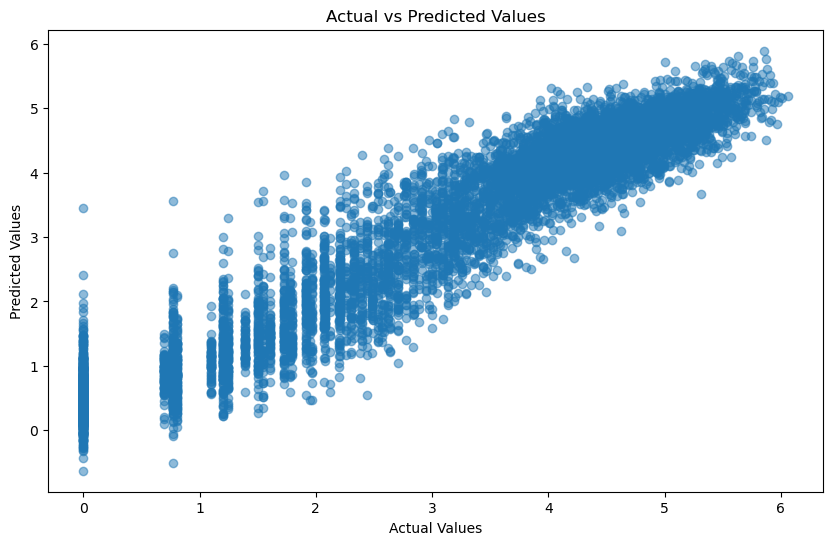

In [3]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

mse = mean_squared_error(actual['scaled_log_bike_count'] ,y_pred_reseasonalized)

# Print the accuracy for each fold
print(mse)

actual['scaled_log_bike_count']
plt.figure(figsize=(10, 6))  
plt.scatter(actual['scaled_log_bike_count'] ,y_pred_reseasonalized, alpha=0.5) 
plt.title("Actual vs Predicted Values") 
plt.xlabel("Actual Values")  
plt.ylabel("Predicted Values")
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)  # Diagonal line
plt.show()

In [4]:
def get_estimator():
    cyclical_encoder = CyclicalEncoder()
    data_encoder = FunctionTransformer(combined_transformer)
    categorical_encoder = OneHotEncoder(handle_unknown="ignore")
    target_cols = ['counter_name']
    categorical_cols = ['weekday','month','season','time_category','year']
    standardize_cols = ['Temperature','distance_paris_centre']
    standardizer = StandardScaler()

    preprocessor = ColumnTransformer(
        [
            ("target_enc", TargetEncoder(), target_cols),
            ("stand", standardizer, standardize_cols),
            ("cat", categorical_encoder, categorical_cols),
        ],remainder='passthrough'
    )
    
    
    regressor = XGBRegressor(
        objective='reg:squarederror',
        subsample=0.5,
        reg_alpha = 0,
        reg_lambda= 10,
        n_estimators = 300,
        max_depth = 10,
        learning_rate=0.05,
        gamma=0,
        colsample_bytree= 0.5,
    )

    
    pipe = make_pipeline(data_encoder ,cyclical_encoder, preprocessor, regressor)
    
    return pipe

df_train = pd.read_parquet('Data/train.parquet')

#df_train['site_name'] = df_train['site_name'].astype(str)
#df_train['site_name'] = df_train['site_name'].replace(r'^Pont des Invalides (S-N|N-S)$', 'Pont des Invalides', regex=True)
#df_train['site_name'] = df_train['site_name'].astype('category')

### IMPLEMENT SCALED FACTOR FOR COVID on df_train
df_train = covid_scaled_count(df_train)
df_train = covid_scaled_log_count(df_train)

df_train['date']=pd.to_datetime(df_train['date'])

weather=pd.read_csv("data/external_data.csv",sep='or|,+', engine='python')
weather=weather[['date','t','ff','vv','u','rr1']]


new_name= {'t' : 'Temperature' , 'ff' : 'average_wind_speed','vv' : 'horizontal_visibility','rr1' : 'rain_l_1'}

weather.rename(columns=new_name,inplace=True)
weather['rain_l_1'].bfill(inplace=True)
weather['date']=pd.to_datetime(weather['date'])


start_date = datetime.strptime('2020-09-01 01:00:00', "%Y-%m-%d %H:%M:%S")
end_date = datetime.strptime('2021-09-09 23:00:00', "%Y-%m-%d %H:%M:%S")

# Filter the DataFrame
weather_train = weather[(start_date <= weather['date']) & (weather['date'] <= end_date)]
weather_train = weather_train.copy()
weather_train.drop(2018, inplace=True)
weather_train = weather_train.set_index('date')

# Resample to hourly and forward fill the missing values
df_hourly = weather_train.resample('H').ffill()

# Reset index to get 'date' back as a column
weather_hourly = df_hourly.reset_index()
df_train.reset_index(inplace=True)
df_train = pd.merge(df_train,weather_hourly,on='date' ) 
df_train.set_index('index',inplace=True)
df_train= df_train.sort_index()

df_train.head()

# Extract features and target
X_train = df_train[df_train['counter_name']==df_train['counter_name'].unique()[3]].drop(columns=['log_bike_count', 'bike_count', 'scaled_bike_count', 'scaled_log_bike_count'])
y_train = df_train[df_train['counter_name']==df_train['counter_name'].unique()[3]][['scaled_log_bike_count']]


actual_2=df_train[df_train['counter_name']==df_train['counter_name'].unique()[3]]
actual_2=actual_2[['date','scaled_log_bike_count']]
pd.to_datetime(actual_2['date'])
actual_2.fillna(method='ffill', inplace=True)
actual_2.set_index('date',inplace=True)
actual_2.sort_index(inplace=True)
     
actual_2=actual_2.asfreq('H')
actual_2.fillna(method='ffill', inplace=True)
    

# Train the model with cross-validation
pipeline = get_estimator()

X_train['date'] = pd.to_datetime(X_train['date'])# Save the current index in a new column  # Convert 'date' to datetime if not already
        
X_train = X_train.set_index('date', drop=False)


X_train.loc[pd.to_datetime('2020-10-25 00:00:00')] = X_train.loc[pd.to_datetime('2020-09-25 01:00:00')] 

# Fit the model on entire training data actual['scaled_log_bike_count']

pipeline.fit(X_train, actual_2['scaled_log_bike_count'])


# Predict on test data
y_pred = pipeline.predict(X_train)



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8229 entries, 2020-09-01 05:00:00 to 2020-10-25 00:00:00
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   counter_name           8229 non-null   object 
 1   Temperature            8229 non-null   float64
 2   rain_l_1               8229 non-null   float64
 3   year                   8229 non-null   int32  
 4   month                  8229 non-null   int32  
 5   weekday                8229 non-null   int32  
 6   hour                   8229 non-null   int32  
 7   distance_paris_centre  8229 non-null   float64
 8   season                 8229 non-null   object 
 9   time_category          8229 non-null   object 
 10  Confinement            8229 non-null   int64  
 11  near_christmas         8229 non-null   int64  
 12  is_weekend             8229 non-null   int64  
dtypes: float64(3), int32(4), int64(3), object(3)
memory usage: 771.5+ KB
Non

RMSE of feature engineered model: 1.2172023728837147
RMSE of seasonalised model: 0.4949136389750942


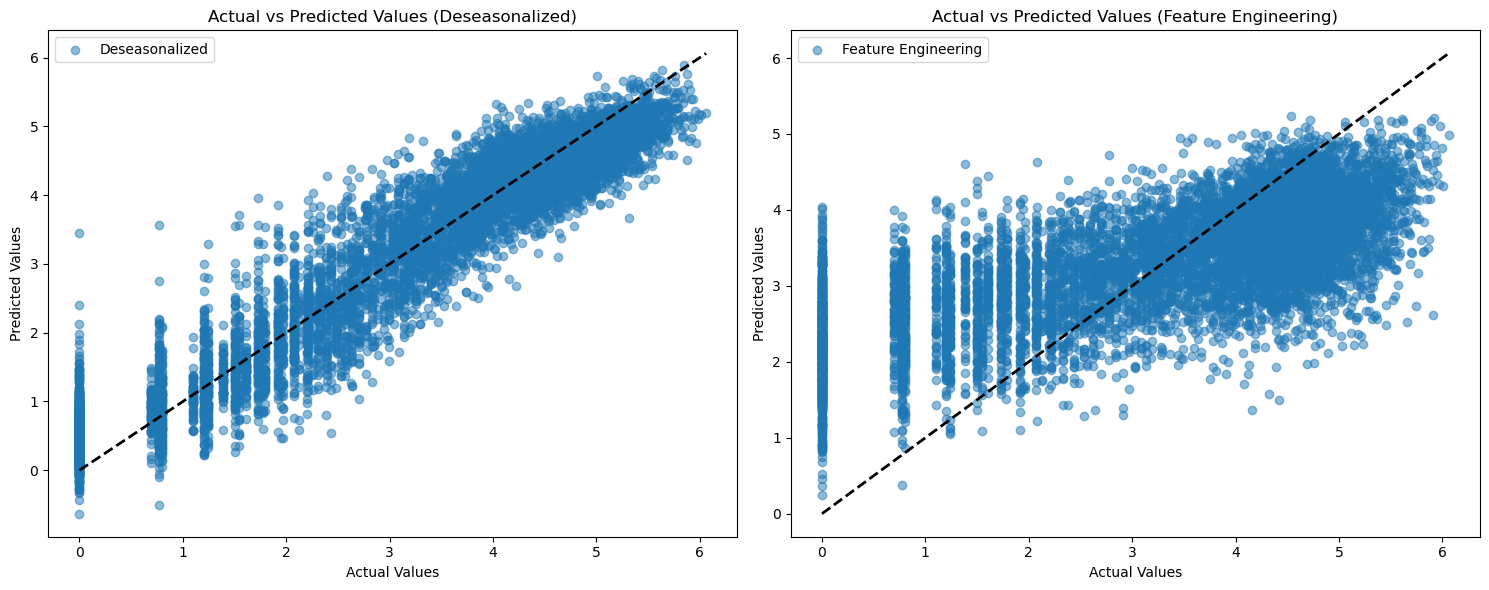

In [7]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

mse = mean_squared_error(actual_2['scaled_log_bike_count'] ,y_pred)
# Print the accuracy for each fold
print(f'RMSE of feature engineered model: {np.sqrt(mse)}')

mse = mean_squared_error(actual['scaled_log_bike_count'] ,y_pred_reseasonalized)
# Print the accuracy for each fold
print(f'RMSE of seasonalised model: {np.sqrt(mse)}')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# First subplot: Deseasonalized
ax1.scatter(actual['scaled_log_bike_count'], y_pred_reseasonalized, alpha=0.5, label='Deseasonalized')
ax1.set_title("Actual vs Predicted Values (Deseasonalized)")
ax1.set_xlabel("Actual Values")
ax1.set_ylabel("Predicted Values")
ax1.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
ax1.legend()

# Second subplot: Feature Engineering
ax2.scatter(actual_2['scaled_log_bike_count'], y_pred, alpha=0.5, label='Feature Engineering')
ax2.set_title("Actual vs Predicted Values (Feature Engineering)")
ax2.set_xlabel("Actual Values")
ax2.set_ylabel("Predicted Values")
ax2.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
ax2.legend()

plt.tight_layout()
plt.show()